In [1]:
import numpy as np
import pandas as pd
import keras
import os
print(keras.__version__)

Using TensorFlow backend.


2.2.2


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1455134087873370363
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7376158720
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3481072334290641731
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image

In [4]:
image_size = 224
num_class = len([x for x in os.listdir('train')])
batch_size = 32
num_channels = 3
train_data_dir = 'train'
validation_data_dir = 'test'

In [5]:
num_class

7

# Transfer learning - Bottleneck

In [6]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [7]:
tr_model=ResNet50(include_top=False,
                  weights='imagenet',
                 input_shape = (224, 224, 3),
                 ) #
#tr_model.summary()

/home/student/anaconda3/envs/tensor/lib/python3.5/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [8]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [9]:
# training set
train_generator = datagen.flow_from_directory(train_data_dir,
                                                    target_size=(image_size,image_size),
                                                    class_mode=None,
                                                    batch_size=batch_size,
                                                    shuffle=False)

bottleneck_features_train = tr_model.predict_generator(train_generator)
train_labels = to_categorical(train_generator.classes , num_classes=num_class)

Found 1083 images belonging to 7 classes.


In [10]:
# Validation set
validation_generator = datagen.flow_from_directory(validation_data_dir, 
                                                        target_size=(image_size,image_size),
                                                        class_mode=None,
                                                        batch_size=batch_size,
                                                       shuffle=False)

bottleneck_features_validation = tr_model.predict_generator(validation_generator)
validation_labels = to_categorical(validation_generator.classes, num_classes=num_class)

Found 538 images belonging to 7 classes.


In [11]:
print(bottleneck_features_train.shape)
print(bottleneck_features_validation.shape)

(1083, 7, 7, 2048)
(538, 7, 7, 2048)


# Model Creation

In [12]:
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, regularizers
model = Sequential()
model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
#model.add(Dense(1024, activation='relu'))

#model.add(BatchNormalization())
#model.add(Dropout(0.8))

model.add(Dense(num_class, activation='softmax', name='pred'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
pred (Dense)                 (None, 7)                 702471    
Total params: 702,471
Trainable params: 702,471
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Early stop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=15, verbose=1, mode='auto')

In [14]:
history = model.fit(bottleneck_features_train, train_labels,
          epochs=50,
          batch_size=batch_size,
          validation_data=(bottleneck_features_validation, validation_labels),
                   callbacks = [early])

Train on 1083 samples, validate on 538 samples
Epoch 1/50
1083/1083 [==============================] - 1s 669us/step - loss: 9.1228 - acc: 0.3306 - val_loss: 8.8106 - val_acc: 0.4126
Epoch 2/50
1083/1083 [==============================] - 0s 314us/step - loss: 8.1169 - acc: 0.4700 - val_loss: 9.9154 - val_acc: 0.3383
Epoch 3/50
1083/1083 [==============================] - 0s 259us/step - loss: 7.7311 - acc: 0.4894 - val_loss: 8.6124 - val_acc: 0.4126
Epoch 4/50
1083/1083 [==============================] - 0s 282us/step - loss: 6.7468 - acc: 0.5503 - val_loss: 9.0015 - val_acc: 0.4071
Epoch 5/50
1083/1083 [==============================] - 0s 333us/step - loss: 6.1249 - acc: 0.5836 - val_loss: 8.4428 - val_acc: 0.4294
Epoch 6/50
1083/1083 [==============================] - 0s 311us/step - loss: 5.4715 - acc: 0.6343 - val_loss: 8.2621 - val_acc: 0.4591
Epoch 7/50
1083/1083 [==============================] - 0s 256us/step - loss: 5.4896 - acc: 0.6297 - val_loss: 8.2966 - val_acc: 0.4554
E

In [15]:
import matplotlib.pyplot as plt
import numpy

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<Figure size 640x480 with 1 Axes>

# Data augmentation

In [16]:
train_datagen = ImageDataGenerator(rotation_range=10,
                                   shear_range=0.2,
                                   channel_shift_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   #rescale=1./255,
                                   preprocessing_function=preprocess_input
                                    )

validation_datagen = ImageDataGenerator(#rescale=1./255,
                                        preprocessing_function=preprocess_input)


train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(image_size,image_size),
                                                    class_mode='categorical',
                                                    batch_size=batch_size,
                                                    shuffle=True)
validation_generator = validation_datagen.flow_from_directory(validation_data_dir, 
                                                        target_size=(image_size,image_size),
                                                        class_mode='categorical',
                                                        batch_size=batch_size,
                                                       shuffle=False)

Found 1083 images belonging to 7 classes.
Found 538 images belonging to 7 classes.


In [17]:
da_model=ResNet50(include_top=False,
                  weights='imagenet',
                 input_shape = (224, 224, 3),
                 )

#da_model.summary()

/home/student/anaconda3/envs/tensor/lib/python3.5/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [18]:
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, regularizers

#Adding custom Layers 
last_layer = da_model.output
x = Flatten()(last_layer)
#x = Dense(1024, activation="relu", name='ds1')(x)
#x = BatchNormalization(name = 'bn')(x)
x = Dropout(0.75, name='do1')(x)

#x = Dense(1024, activation="relu", name='ds2')(x)

# add a global spatial average pooling layer
# add fully-connected & dropout layers
#x = Dense(512, activation='relu',name='fc-1')(x)
#x = Dropout(0.5)(x)
#x = Dense(256, activation='relu',name='fc-2')(x)
#x = Dropout(0.5)(x)


predictions = Dense(num_class, activation="softmax", name='pred')(x)

In [19]:
# creating the final model 
model_final = Model(inputs = da_model.input, outputs = predictions)
#model_final.summary()

In [20]:
# Freeze the layers which you don't want to train. 
layernum = 0
for layer in model_final.layers[::-1]:
    layernum += 1
    if layer.name in ['ds1', 'ds2', 'pred', 'do1', 'bn', 'res5c_branch2c', 'bn5c_branch2c', 'res5c_branch2a', 'bn5c_branch2a', 'res5c_branch2b', 'bn5c_branch2b']:
        layer.trainable = True
        print('trainable  --> ', layer.name)
    else:
        layer.trainable = False
#model_final.summary()


trainable  -->  pred
trainable  -->  do1
trainable  -->  bn5c_branch2c
trainable  -->  res5c_branch2c
trainable  -->  bn5c_branch2b
trainable  -->  res5c_branch2b
trainable  -->  bn5c_branch2a
trainable  -->  res5c_branch2a


In [21]:
# Early stop
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

# compile the model 
model_final.compile(loss = 'categorical_crossentropy',
                     optimizer = 'adam', #optimizers.SGD(lr=0.001),
                     metrics=["acc"])

In [22]:
# Train the model 

history = model_final.fit_generator(
        train_generator,
        epochs = 100,
        steps_per_epoch=len(train_generator.filenames) // batch_size,
        validation_steps=len(validation_generator.filenames) // batch_size,
        #workers=4,
        validation_data = validation_generator,
        callbacks = [early]
         )

Epoch 1/100
33/33 [==============================] - 19s 570ms/step - loss: 6.4364 - acc: 0.3355 - val_loss: 7.1448 - val_acc: 0.3327
Epoch 2/100
33/33 [==============================] - 18s 547ms/step - loss: 5.6843 - acc: 0.3989 - val_loss: 8.7271 - val_acc: 0.3141
Epoch 3/100
33/33 [==============================] - 18s 540ms/step - loss: 6.0004 - acc: 0.4320 - val_loss: 6.9284 - val_acc: 0.4572
Epoch 4/100
33/33 [==============================] - 17s 528ms/step - loss: 6.0614 - acc: 0.4456 - val_loss: 7.2377 - val_acc: 0.4461
Epoch 5/100
33/33 [==============================] - 17s 513ms/step - loss: 5.9081 - acc: 0.4763 - val_loss: 7.0253 - val_acc: 0.4851
Epoch 6/100
33/33 [==============================] - 17s 501ms/step - loss: 6.0386 - acc: 0.5019 - val_loss: 7.0443 - val_acc: 0.4814
Epoch 7/100
33/33 [==============================] - 17s 505ms/step - loss: 5.8474 - acc: 0.5360 - val_loss: 6.9965 - val_acc: 0.4777
Epoch 8/100
33/33 [==============================] - 17s 501ms

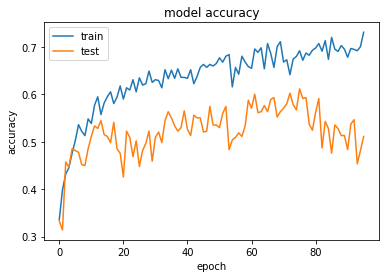

In [23]:
import matplotlib.pyplot as plt
import numpy

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()